# Noise and Error Mitigitation on Quantum Real Circuits 
## Basado en el siguiente tutorial:
https://github.com/qiskit-community/qiskit-community-tutorials/blob/master/Coding_With_Qiskit/ep8_Noise_and_Error_Mitigation.ipynb

In [1]:
import numpy as np

# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile, Aer, IBMQ
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *
from qiskit.providers.aer import QasmSimulator


In [2]:
from qiskit.providers.ibmq import least_busy
from qiskit.tools.monitor import job_monitor

In [3]:
from qiskit import *

In [4]:
# Descomente la siguiente linea si desea ver las imágenes más grandes.
%config InlineBackend.figure_format = 'svg' # Makes the images look nice

In [5]:
nqubits = 3

## Circuit No. 1

In [6]:
circuit1 = QuantumCircuit(nqubits, nqubits)
circuit1.h(0)
circuit1.cx(0,1)
circuit1.cx(1,2)
circuit1.measure([0,1,2], [0,1,2])

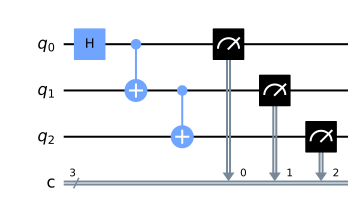

In [7]:
circuit1.draw(output='mpl')

In [8]:
simulator = Aer.get_backend('qasm_simulator')
sim_result = execute(circuit1, backend=simulator, shots=1024).result()

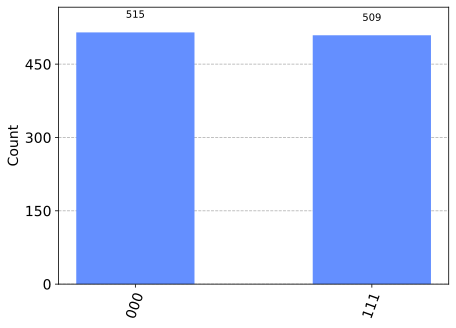

In [9]:
from qiskit.visualization import plot_histogram
plot_histogram(sim_result.get_counts(circuit1))

In [10]:
# First, see what devices we are allowed to use by loading our saved accounts
IBMQ.load_account()
#provider = IBMQ.get_provider(hub='ibm-q')
provider = IBMQ.get_provider(hub='ibm-q-education', group='uni-antioquia-2', project='quantum-alg')

#Remote_QProcessor = provider.get_backend('ibm_perth')
#Remote_QSimulator = provider.get_backend('ibmq_qasm_simulator')

/tmp/ipykernel_102/1409322788.py:3: DeprecationWarning: The qiskit.IBMQ entrypoint and the qiskit-ibmq-provider package (accessible from 'qiskit.providers.ibmq`) are deprecated and will be removed in a future release. Instead you should use the qiskit-ibm-provider package which is accessible from 'qiskit_ibm_provider'. You can install it with 'pip install qiskit_ibm_provider'. Just replace 'qiskit.IBMQ' with 'qiskit_ibm_provider.IBMProvider'
  IBMQ.load_account()


In [11]:
#Remote_QProcessor = least_busy(provider.backends(filters=lambda qprocessor: qprocessor.configuration().n_qubits >= 2 
#                                       and not qprocessor.configuration().simulator 
#                                       and qprocessor.status().operational==True))
#print("El computador cuántico menos ocupado es el " + Remote_QProcessor.name())

In [12]:
#Remote_QProcessor = provider.get_backend('ibm_lagos') Maquina reservada temporalmente
Remote_QProcessor = provider.get_backend('ibm_oslo')

In [13]:
job = execute(circuit1, backend=Remote_QProcessor, shots=1024)
print(job.job_id())
#job_monitor(job)

64243c5916297180c320d78f


In [14]:
#job2=Remote_QProcessor.jobs()[0]
#job2=Remote_QProcessor.retrieve_job('642320472b88c433e598f63f')
#job2.status()

In [15]:
device_result = job.result()
#device_result = job2.result()

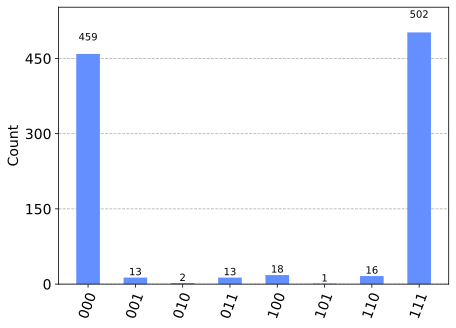

In [16]:
plot_histogram(device_result.get_counts(circuit1))

# Definition of Calibration Circuits to mitigate the measurement error.

In [17]:
#from qiskit.ignis.mitigation.measurement import complete_meas_cal, CompleteMeasFitter
from qiskit.utils.mitigation import (complete_meas_cal, tensored_meas_cal,
                                        CompleteMeasFitter, TensoredMeasFitter)

In [18]:
calibration_circuits, quantum_states = complete_meas_cal(qr=circuit1.qregs[0], 
                                               circlabel='measurement_calibration')

In [19]:
quantum_states

['000', '001', '010', '011', '100', '101', '110', '111']

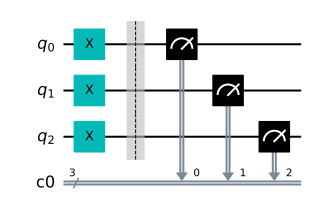

In [20]:
calibration_circuits[7].draw(output='mpl')

In [21]:
len(calibration_circuits)

8

In [22]:
cal_job = execute(calibration_circuits,
             backend=Remote_QProcessor,
             shots=8192,
             optimization_level=0)
print(cal_job.job_id())
#job_monitor(cal_job)

64243e24a101f2dc25873931


In [23]:
#job2=Remote_QProcessor.jobs()[0]
#cal_job2=Remote_QProcessor.retrieve_job('642323a74f6f1c0796aacc93')
#cal_job2.status()

In [24]:
calibration_results = cal_job.result()
#calibration_results = cal_job2.result()

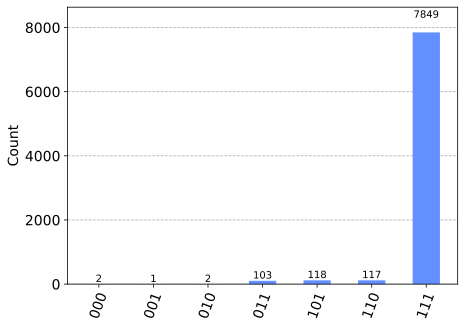

In [25]:
plot_histogram(calibration_results.get_counts(calibration_circuits[7]))

In [26]:
calibration_results.get_counts(calibration_circuits[7])

{'000': 2, '001': 1, '010': 2, '011': 103, '101': 118, '110': 117, '111': 7849}

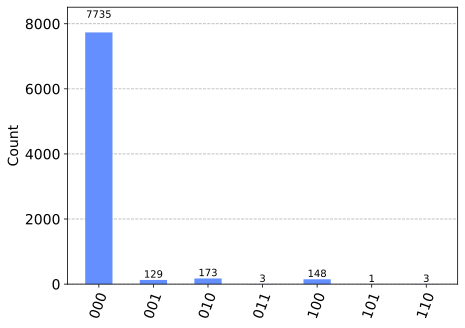

In [27]:
plot_histogram(calibration_results.get_counts(calibration_circuits[0]))

In [28]:
calibration_results.get_counts(calibration_circuits[0])

{'000': 7735, '001': 129, '010': 173, '011': 3, '100': 148, '101': 1, '110': 3}

In [29]:
#for state in quantum_states:
#    qc = QuantumCircuit(3,3)
#    if state[0]=='1':
#        qc.x(1)
#    if state[1]=='1':
#        qc.x(0)  
#    qc.measure([0, 1, 2], [0, 1, 2])
#    t_qc = transpile(qc, aer_sim)
#    qobj = assemble(t_qc)
#    counts = aer_sim.run(qobj, noise_model=noise_model, shots=8192).result().get_counts()
    
#    calibration_results.get_counts(calibration_circuits[3])    
    
print('000 becomes', calibration_results.get_counts(calibration_circuits[0]))
print('001 becomes', calibration_results.get_counts(calibration_circuits[1]))
print('010 becomes', calibration_results.get_counts(calibration_circuits[2]))
print('011 becomes', calibration_results.get_counts(calibration_circuits[3]))
print('100 becomes', calibration_results.get_counts(calibration_circuits[4]))
print('101 becomes', calibration_results.get_counts(calibration_circuits[5]))
print('110 becomes', calibration_results.get_counts(calibration_circuits[6]))
print('111 becomes', calibration_results.get_counts(calibration_circuits[7]))

000 becomes {'000': 7735, '001': 129, '010': 173, '011': 3, '100': 148, '101': 1, '110': 3}
001 becomes {'000': 103, '001': 7811, '010': 4, '011': 123, '100': 2, '101': 141, '110': 1, '111': 7}
010 becomes {'000': 129, '001': 3, '010': 7768, '011': 129, '100': 8, '110': 153, '111': 2}
011 becomes {'000': 3, '001': 122, '010': 115, '011': 7714, '100': 1, '101': 6, '110': 55, '111': 176}
100 becomes {'000': 118, '001': 11, '010': 4, '011': 1, '100': 7759, '101': 136, '110': 160, '111': 3}
101 becomes {'001': 108, '011': 6, '100': 135, '101': 7795, '110': 4, '111': 144}
110 becomes {'000': 5, '001': 1, '010': 125, '011': 74, '100': 141, '101': 2, '110': 7712, '111': 132}
111 becomes {'000': 2, '001': 1, '010': 2, '011': 103, '101': 118, '110': 117, '111': 7849}


In [30]:
My_fitter = CompleteMeasFitter(calibration_results, quantum_states)

In [31]:
from qiskit.visualization import array_to_latex
array_to_latex(My_fitter.cal_matrix)

<IPython.core.display.Latex object>

In [32]:
#My_fitter.plot_calibration()

In [33]:
Measurement_Filter = My_fitter.filter

# Mitigating the measurement errors in our previous device run

In [34]:
mitigated_result = Measurement_Filter.apply(device_result)

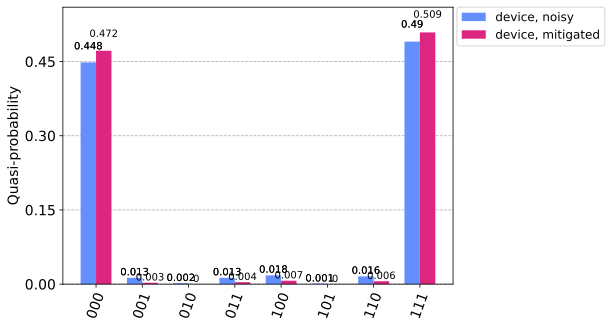

In [35]:
device_counts = device_result.get_counts(circuit1)
mitigated_counts = mitigated_result.get_counts(circuit1)
plot_histogram([device_counts, mitigated_counts], 
               legend=['device, noisy', 'device, mitigated'])

# Running error mitigation on a second circuit
## Circuit No. 2

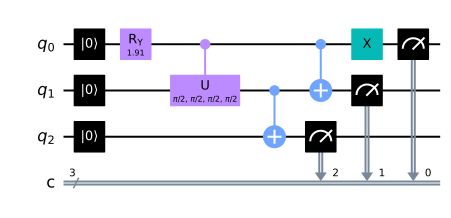

In [36]:
from ibm_quantum_widgets import CircuitComposer
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from numpy import pi

qreg_q = QuantumRegister(3, 'q')
creg_c = ClassicalRegister(3, 'c')
circuit2 = QuantumCircuit(qreg_q, creg_c)

circuit2.reset(qreg_q[0])
circuit2.reset(qreg_q[1])
circuit2.reset(qreg_q[2])
circuit2.ry(1.9106332362490184, qreg_q[0])
circuit2.cu(pi / 2, pi / 2, pi / 2, pi / 2, qreg_q[0], qreg_q[1])
circuit2.cx(qreg_q[1], qreg_q[2])
circuit2.cx(qreg_q[0], qreg_q[1])
circuit2.x(qreg_q[0])
circuit2.measure(qreg_q[0], creg_c[0])
circuit2.measure(qreg_q[1], creg_c[1])
circuit2.measure(qreg_q[2], creg_c[2])

circuit2.draw(output='mpl')

In [37]:
#circuit2 = QuantumCircuit(3,3)
#circuit2.x(1)
#circuit2.h(0)
#circuit2.cx(0,1)
#circuit2.cx(1,2)
#circuit2.measure([0,1,2], [0,1,2])
#circuit2.draw(output='mpl')

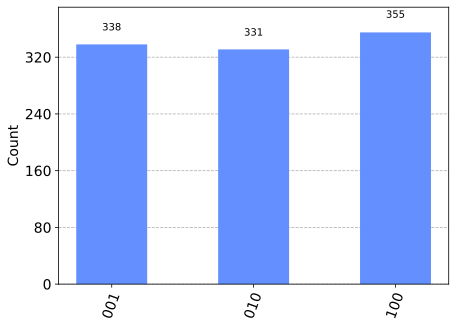

In [38]:
# Simulating the circuit and plotting the corresponding histogram:
Simulation_counts_2 = execute(circuit2, backend=simulator, shots=1024).result().get_counts(circuit2)
plot_histogram(Simulation_counts_2)

In [39]:
# Executing the circuit and plotting the corresponding histogram:
job2 = execute(circuit2, backend=Remote_QProcessor, shots=1024)
print(job2.job_id())
#job_monitor(job2_retrieve)

64243e6d2e67a76125fc9fcd


In [40]:
#job2_retrieve=Remote_QProcessor.jobs()[0]
#job2_retrieve=Remote_QProcessor.retrieve_job('642326192b88c44e6898f64a')

#job2_retrieve.status()

In [41]:
device_counts_2 = job2.result().get_counts(circuit2)
#device_counts_2 = job2_retrieve.result().get_counts(circuit2)

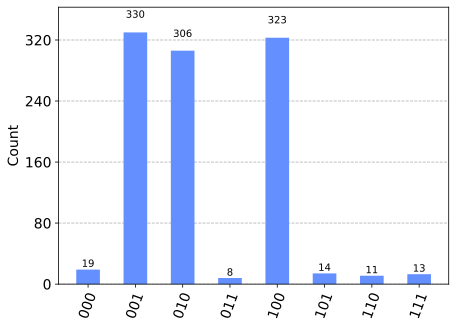

In [42]:
plot_histogram(device_counts_2)

In [43]:
mitigated_counts_2 = Measurement_Filter.apply(device_counts_2)

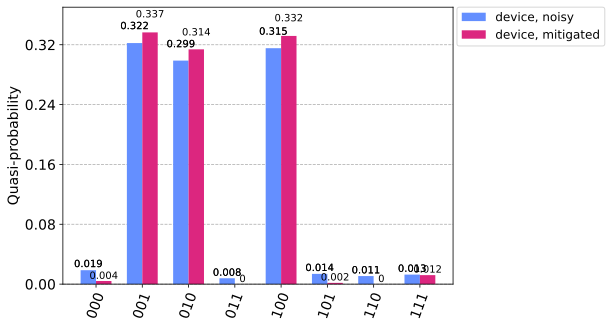

In [44]:
plot_histogram([device_counts_2, mitigated_counts_2], 
               legend=['device, noisy', 'device, mitigated'])

In [45]:
import qiskit.tools.jupyter
%qiskit_version_table
%qiskit_copyright